In [1]:
import pandas as pd
import scipy.io
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import collections
import json
import matlab.engine
from sklearn.linear_model import LinearRegression

In [2]:
bus = scipy.io.loadmat('MATPOWER/bus.mat')['bus']
power_demand = bus[:, 2]
df = pd.read_csv("GIS/CATS_gens.csv").to_numpy()
#df = df[df['Pmax'] != 0.0].to_numpy()
old_num_gen = len(df)
#df = df.drop_duplicates(subset=['PlantCode','GenID']).to_numpy()
indices = []
idx = []
for i, r in enumerate(df):
    if r[3] == "IMPORT" or r[5] == 0.0:
        indices.append(i+1)
        idx.append(i)
bus_loc = pd.read_csv("GIS/CATS_buses.csv").to_numpy()[:, [4,5]]
gen_loc = df[:, -2:]
df = pd.read_csv("GIS/CATS_gens.csv").drop(index=idx).to_numpy()
eng = matlab.engine.start_matlab()
#real_gen = pd.read_csv('data/CAISO-demand-20191101.csv').iloc[[2]].to_numpy().reshape((290, ))[1:]
g = eng.removeSolar(indices)
m = eng.loadcase('CaliforniaTestSystem.m')
num_bus = np.array(m['bus']).shape[0]
num_branch = np.array(m['branch']).shape[0]
num_gen = np.array(m['gen']).shape[0]
eng.quit()

In [3]:
gen_by_fuel = collections.defaultdict(float)
for row in df:
    gen_by_fuel[row[3]] += row[5]
gen_by_fuel

defaultdict(float,
            {'Conventional Hydroelectric': 7922.999999999999,
             'Petroleum Liquids': 369.09999999999997,
             'Natural Gas Fired Combustion Turbine': 10893.39999999999,
             'Natural Gas Internal Combustion Engine': 325.5999999999998,
             'Natural Gas Fired Combined Cycle': 19649.300000000007,
             'Natural Gas Steam Turbine': 4744.799999999999,
             'Landfill Gas': 278.6,
             'Batteries': 229.50000000000003,
             'Hydroelectric Pumped Storage': 759.1,
             'Geothermal': 1095.2,
             'Nuclear': 2323.0,
             'Onshore Wind Turbine': 5303.000000000001,
             'Other Waste Biomass': 168.5999999999999,
             'Wood/Wood Waste Biomass': 504.8,
             'Solar Photovoltaic': 11639.398672710053,
             'Solar Thermal without Energy Storage': 1156.00132935,
             'All Other': 113.69999999999999,
             'Conventional Steam Coal': 55.0,
             'O

([<matplotlib.patches.Wedge at 0x139e2acaf90>,
 [Text(-0.08931493580833179, 1.0963680231754087, 'Natural Gas'),
  Text(-0.8018840444043942, -0.752982057774056, 'Solar'),
  Text(-0.12959145681631756, -1.0923397156197447, 'Nuclear'),
  Text(-0.00899391927902355, -1.0999632309381993, 'Coal'),
  Text(0.42394047700224124, -1.015024370130645, 'Hydro'),
  Text(0.8110938095311272, -0.7430523750990126, 'Biomass'),
  Text(0.858620130329737, -0.6875837925609835, 'Other'),
  Text(0.9137734038198234, -0.6123872683780537, 'Geothermal'),
  Text(1.052575096455243, -0.3195084761351973, 'Wind'),
  Text(1.0986465526997584, -0.054550455918692585, 'Import'),
  Text(1.0996615802762029, -0.02728385721345938, 'Biogas')],
 [Text(-0.048717237713635515, 0.5980189217320411, '52.6%'),
  Text(-0.43739129694785134, -0.41071748605857594, '18.8%'),
  Text(-0.07068624917253685, -0.5958216630653153, '3.4%'),
  Text(-0.004905774152194664, -0.5999799441481086, '0.1%'),
  Text(0.23124026018304064, -0.5536496564348972, '12.

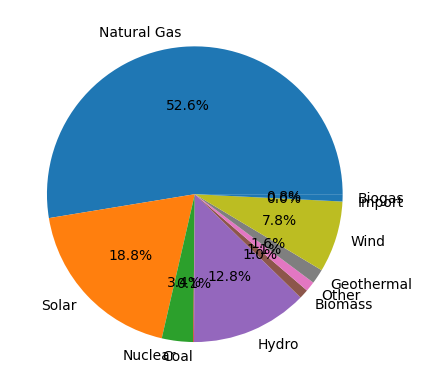

In [4]:
y = [0]*11
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        y[0] += v
    elif 'Solar' in k:
        y[1] += v
    elif 'Nuclear' in k:
        y[2] += v
    elif 'Coal' in k:
        y[3] += v
    elif 'Hydro' in k:
        y[4] += v
    elif 'Biomass' in k or 'Waste' in k:
        y[5] += v
    elif 'Geothermal' in k:
        y[7] += v
    elif 'Wind' in k:
        y[8] += v
    elif 'IMPORT' in k:
        y[9] += v
    elif 'Landfill' in k or 'Other Gases' in k:
        y[10] += v
    else:
        y[6] += v
x = ['Natural Gas', 'Solar','Nuclear','Coal','Hydro','Biomass','Other','Geothermal','Wind','Import','Biogas']
fig, ax = plt.subplots()
ax.pie(y, labels=x,autopct='%1.1f%%')

In [5]:
# https://www.eia.gov/electricity/data/emissions/
gen_emission = pd.read_excel("data/emissions2019.xlsx")
gen_emission = gen_emission[gen_emission['Generation (kWh)'] > 0]
gen_emission = gen_emission[gen_emission['State'] == 'CA']
gen_emission = gen_emission[['Plant Code','Fuel Code','Aggregated Fuel Group','Generation (kWh)','Metric Tonnes of CO2 Emissions','carbon emission rate']]
d1 = gen_emission.groupby(['Aggregated Fuel Group'])['Generation (kWh)'].sum()
d2 = gen_emission.groupby(['Aggregated Fuel Group'])['Metric Tonnes of CO2 Emissions'].sum()
d2*1000/d1
# get carbon emssion rate of each fuel type (tons/mWh)

Aggregated Fuel Group
COAL    4.692794
GAS     0.455939
GEO     0.026307
MSW     0.834946
PET     0.878813
dtype: float64

In [6]:
gen_emission.groupby(['Fuel Code'])['carbon emission rate'].median()

Fuel Code
BIT    4.642909
DFO    1.191675
GEO    0.026307
JF     1.180994
MSW    0.834394
NG     0.585267
PG     1.083609
RC     4.693628
WO     0.534195
Name: carbon emission rate, dtype: float64

In [5]:
type_to_emission = collections.defaultdict(float)
#type_to_emission['Conventional Hydroelectric'] = 0
#type_to_emission['Hydroelectric Pumped Storage'] = 0
type_to_emission['Petroleum Liquids'] = 1.114133
type_to_emission['Natural Gas Internal Combustion Engine'] = 0.455939
type_to_emission['Natural Gas Fired Combined Cycle'] = 0.455939
type_to_emission['Natural Gas Steam Turbine'] = 0.455939
type_to_emission['Natural Gas Fired Combustion Turbine'] = 0.455939
type_to_emission['Nuclear'] = 0
type_to_emission['Geothermal'] = 0.058489
#type_to_emission['Onshore Wind Turbine'] = 0
type_to_emission['Other Waste Biomass'] = 0.029702
type_to_emission['Wood/Wood Waste Biomass'] = 0.029702
type_to_emission['Landfill Gas'] = 0.776560
#type_to_emission['Solar Photovoltaic'] = 0
#type_to_emission['Solar Thermal without Energy Storage'] = 0
type_to_emission['Conventional Steam Coal'] = 0.531497
type_to_emission['Other Gases'] = 0.776560
type_to_emission['Batteries'] = 0
type_to_emission['Petroleum Coke'] = 1.114133
type_to_emission['Municipal Solid Waste'] = 0.029702
type_to_emission['Other Natural Gas'] = 0.455939
type_to_emission['All Other'] = 0.104261
#type_to_emission['IMPORT'] = 0.104261*1.7
#type_to_emission['Synchronous Condenser'] = 884
for k, v in type_to_emission.items():
    type_to_emission[k] *= 2.7

In [8]:
# https://www.epa.gov/egrid
emission_power_plant = pd.read_excel("data/emission_egrid.xlsx")
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant["plant_emission_rate"] = emission_power_plant["Plant annual CO2 emissions"]/emission_power_plant["Plant annual net generation"]

In [9]:
emission_power_plant.groupby(['Plant primary coal/oil/gas/ other fossil fuel category'])['plant_emission_rate'].mean()

Plant primary coal/oil/gas/ other fossil fuel category
BIOMASS       0.031964
COAL          0.574314
GAS           0.392918
GEOTHERMAL    0.064474
HYDRO         0.000000
NUCLEAR       0.000000
OFSL          0.420986
OIL           1.114133
OTHF          0.302718
SOLAR         0.000501
WIND          0.000000
Name: plant_emission_rate, dtype: float64

In [10]:
# egrid_2019
# https://www.epa.gov/egrid
# we have percent mixure of power generation by fuel types. We have carbon emission rate of each generator. We can get the carbon emission rate of the each fuel type.
emission_power_plant = pd.read_excel("data/Book1.xlsx")
pd.set_option('display.max_columns', None)
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation (MWh)'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant['Plant annual CO2 equivalent total output emission rate (metric tons/MWh)'] = emission_power_plant['Plant annual CO2 equivalent total output emission rate (lb/MWh)']/2204.62
emission_power_plant.head(5)

,Plant state abbreviation,DOE/EIA ORIS plant or facility code,Utility ID,Plant FIPS county code,Plant latitude,Plant longitude,Plant primary fuel,Plant primary coal/oil/gas/ other fossil fuel category,Plant annual net generation (MWh),Plant annual CO2 equivalent emissions (tons),Plant annual CO2 equivalent total output emission rate (lb/MWh),Plant coal generation percent (resource mix),Plant oil generation percent (resource mix),Plant gas generation percent (resource mix),Plant nuclear generation percent (resource mix),Plant hydro generation percent (resource mix),Plant biomass generation percent (resource mix),Plant wind generation percent (resource mix),Plant solar generation percent (resource mix),Plant geothermal generation percent (resource mix),Plant other fossil generation percent (resource mix),Plant other unknown / purchased fuel generation percent (resource mix),Plant annual CO2 equivalent total output emission rate (metric tons/MWh)
474,CA,57310,57320,37.0,33.794283,-118.241405,SUN,SOLAR,1781.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
475,CA,58918,61315,19.0,36.670000,-119.415833,SUN,SOLAR,1535.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
476,CA,58920,61315,47.0,37.352222,-120.506944,SUN,SOLAR,2656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
477,CA,58919,61315,7.0,39.291667,-121.669722,SUN,SOLAR,2410.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
478,CA,57871,11208,37.0,34.026944,-118.224167,SUN,SOLAR,1252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
# Use least square. Percent fuel type of each gen * carbon emission of each fuel type = carbon emission of each gen
A = emission_power_plant.to_numpy()[:, 11:-1]
b = emission_power_plant.to_numpy()[:, -1]
x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type
dict_carb = collections.defaultdict(float)
dict_carb["Coal"] = x[0]
dict_carb["Oil"] = x[1]
dict_carb["Gas"] = x[2]
dict_carb["Nuclear"] = x[3]
dict_carb["Hydro"] = x[4]
dict_carb["Biomass"] = x[5]
dict_carb["Wind"] = x[6]
dict_carb["Solar"] = x[7]
dict_carb["Geothermal"] = x[8]
dict_carb["Other fossil"] = x[9]
dict_carb["Other/Import"] = x[10]

C:\Users\syq41\AppData\Local\Temp\ipykernel_22008\2484647333.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type


In [12]:
dict_carb

defaultdict(float,
            {'Coal': 0.5314975802795217,
             'Oil': 1.3178187916140418,
             'Gas': 0.3582052877233134,
             'Nuclear': 4.440892098500626e-16,
             'Hydro': 1.1102230246251565e-16,
             'Biomass': 0.029702157130995444,
             'Wind': 4.556679422329091e-18,
             'Solar': 0.00040708553821955373,
             'Geothermal': 0.0584896013043455,
             'Other fossil': 0.6539273187952721,
             'Other/Import': 0.10426143309084011})

In [14]:
# emission rate of gen based on clostest distance in real gen data
'''emission_power_plant = emission_power_plant.to_numpy()[:, [3,4,9]]
carbon_emission = [0]*2149
for i, v in enumerate(gen_loc):
    coords_1 = (v[0], v[1])
    min_dist = math.inf
    for x2, y2, e2 in emission_power_plant:
        coords_2 = (x2, y2)
        distance = geopy.distance.geodesic(coords_1, coords_2).km
        if distance < min_dist:
            carbon_emission[i] = e2
            min_dist = distance'''

'emission_power_plant = emission_power_plant.to_numpy()[:, [3,4,9]]\ncarbon_emission = [0]*2149\nfor i, v in enumerate(gen_loc):\n    coords_1 = (v[0], v[1])\n    min_dist = math.inf\n    for x2, y2, e2 in emission_power_plant:\n        coords_2 = (x2, y2)\n        distance = geopy.distance.geodesic(coords_1, coords_2).km\n        if distance < min_dist:\n            carbon_emission[i] = e2\n            min_dist = distance'

In [6]:
branch_ = scipy.io.loadmat('MATPOWER/branch.mat')['brach']
branch_from_bus = list(map(int, branch_[:, 0]-1))
branch_to_bus = list(map(int, branch_[:, 1]-1))
line_to_nodes = [list(map(int,i) ) for i in branch_[:, 0:2]-1]

In [7]:
!julia run_opf.jl
f = open("pf_solution.json")
gen_by_fuel = collections.defaultdict(float)
sol = json.load(f)
gen = [0]*num_gen
gen_cost = [0]*num_gen
power_generation = [0]*num_gen
carbon_emission = [0]*num_gen
branch_power_to = [0]*num_branch
branch_power_from = [0]*num_branch
res = []
for line, val in sol['solution']['gen'].items():
    if val['pg'] != 0.0:
        gen[int(line)-1] = df[int(line)-1][2]-1
        carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
        gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
        gen_cost[int(line)-1] = val['pg_cost']
        power_generation[int(line)-1] = val['pg']*100

for line, val in sol['solution']['branch'].items():
    branch_power_from[int(line)-1] = val['pf']*100
    branch_power_to[int(line)-1] = val['pt']*100

f.close()

[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


In [8]:
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
for i, (from_bus, to_bus) in enumerate(line_to_nodes):
    graph[from_bus].append((to_bus, i))
    graph_reverse[to_bus].append((from_bus, i))
for i, f in enumerate(branch_power_from):
    if f < 0.0:
        from_node, to_node = line_to_nodes[i]
        graph[from_node].remove((to_node, i))
        graph[to_node].append((from_node, i))
        graph_reverse[to_node].remove((from_node, i))
        graph_reverse[from_node].append((to_node, i))
        branch_power_from[i] = -f

In [9]:
# find branches and buses reachable from non renewable generators
visited = set()
visited_b = set()
def find_components(graph, n, visited):
    if n in visited: return
    visited.add(n)
    for nei, line in graph[n]:
        visited_b.add(line)
        find_components(graph, nei, visited)
for i in range(num_gen):
    n = gen[i]
    if n not in visited:
        find_components(graph, n, visited)
indx_rm = [i+1 for i in list(set(range(num_bus)) - visited)]
indx_line = [i+1 for i in list(set(range(num_branch)) - visited_b)]
eng = matlab.engine.start_matlab()
#real_gen = pd.read_csv('data/CAISO-demand-20191101.csv').iloc[[2]].to_numpy().reshape((290, ))[1:]
g = eng.removeBus(indx_rm, indx_line)
m = eng.loadcase('CaliforniaTestSystem.m')
num_bus = np.array(m['bus']).shape[0]
num_branch = np.array(m['branch']).shape[0]
line_to_nodes = [list(map(int,i)) for i in np.array(m['branch'])[:, 0:2]-1]
eng.quit()

In [10]:
!julia run_opf.jl
f = open("pf_solution.json")
gen_by_fuel = collections.defaultdict(float)
sol = json.load(f)
gen = [-1]*num_gen
gen_cost = [0]*num_gen
power_generation = [0]*num_gen
carbon_emission = [0]*num_gen
branch_power_to = [0]*num_branch
branch_power_from = [0]*num_branch
res = []
for line, val in sol['solution']['gen'].items():
    if val['pg'] != 0.0:
        gen[int(line)-1] = df[int(line)-1][2]-1
        carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
        gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
        gen_cost[int(line)-1] = val['pg_cost']
        power_generation[int(line)-1] = val['pg']*100

for line, val in sol['solution']['branch'].items():
    branch_power_from[int(line)-1] = val['pf']*100
    branch_power_to[int(line)-1] = val['pt']*100

f.close()
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
for i, (from_bus, to_bus) in enumerate(line_to_nodes):
    graph[from_bus].append((to_bus, i))
    graph_reverse[to_bus].append((from_bus, i))
for i, f in enumerate(branch_power_from):
    if f < 0.0:
        from_node, to_node = line_to_nodes[i]
        graph[from_node].remove((to_node, i))
        graph[to_node].append((from_node, i))
        graph_reverse[to_node].remove((from_node, i))
        graph_reverse[from_node].append((to_node, i))
        branch_power_from[i] = -f

[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


In [11]:
# Kahn's algo
def topo_order_kahn(graph):
    in_degree = [0]*num_bus
    for i in range(num_bus):
        for nei, _ in graph[i]:
            in_degree[nei] += 1
    q = []
    for i in range(num_bus):
        if in_degree[i] == 0:
            q.append(i)
    index = 0
    order = [0]*num_bus
    while q:
        at = q.pop(0)
        order[index] = at
        index += 1
        for nei, _ in graph[at]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    return in_degree

In [114]:
# find cycles
'''def dfs_cycle(graph, n, visiting, curPath, start, visited, cycles):
    if visiting[n]:
        #if n == start:
        idx = curPath.index(n)
        cycles.add(frozenset(curPath[idx:]))
        for j in curPath[idx:]:
            visited[j] = True
        return
    visiting[n] = True
    curPath.append(n)
    for nei, _ in graph[n]:
        dfs_cycle(graph, nei, visiting, curPath, start, visited, cycles)
    visiting[n] = False
    curPath.pop(-1)
    
cycles = set()
visited = [False]*num_bus
for n in range(num_bus):
    if not visited[n]:
        start = n
        visiting = [False]*num_bus
        dfs_cycle(graph, n, visiting, [], start, visited, cycles)'''

'def dfs_cycle(graph, n, visiting, curPath, start, visited, cycles):\n    if visiting[n]:\n        #if n == start:\n        idx = curPath.index(n)\n        cycles.add(frozenset(curPath[idx:]))\n        for j in curPath[idx:]:\n            visited[j] = True\n        return\n    visiting[n] = True\n    curPath.append(n)\n    for nei, _ in graph[n]:\n        dfs_cycle(graph, nei, visiting, curPath, start, visited, cycles)\n    visiting[n] = False\n    curPath.pop(-1)\n    \ncycles = set()\nvisited = [False]*num_bus\nfor n in range(num_bus):\n    if not visited[n]:\n        start = n\n        visiting = [False]*num_bus\n        dfs_cycle(graph, n, visiting, [], start, visited, cycles)'

In [12]:
# find number of components in graph
visited = set()
num_components = 0
def find_components(graph, n, visited):
    if n in visited: return
    visited.add(n)
    for nei, _ in graph[n]:
        find_components(graph, nei, visited)
for n in range(num_bus):
    if n not in visited:
        find_components(graph, n, visited)
        num_components += 1
num_components
# we get num_compoents = 770

836

In [13]:
def update_graph_DAG(graph, c):
    for b in c:
        for nei, line in graph[b]:
            if nei in c:
                branch_power_from[line] = 0
                graph[b].remove((nei, line))
        for nei, line in graph_reverse[b]:
            if nei in c:
                branch_power_from[line] = 0
                if (b, line) in graph[nei]:
                    graph[nei].remove((b, line))
        if b != c[0]:
            for nei, line in graph[b]:
                if nei not in c:
                    graph[c[0]].append((nei, line))
                    graph[b].remove((nei, line))
            for nei, line in graph_reverse[b]:
                if nei not in c:
                    graph[nei].append((c[0], line))
                    if (b, line) in graph[nei]:
                        graph[nei].remove((b, line))
            graph[b] = []
    return graph

In [14]:
# Tarjan's Strongly Connected Component (SCC) Algorithm
UNVISITED = -1
id = [0]
sccCount = [0]
ids = [0]*num_bus
low = [0]*num_bus
onStack = [False]*num_bus
stack = []
def findSccs():
    for i in range(num_bus): ids[i] = UNVISITED
    for i in range(num_bus):
        if ids[i] == UNVISITED:
            tarjan_dfs(i)
    return low
def tarjan_dfs(at):
    stack.append(at)
    onStack[at] = True
    ids[at] = id[0]
    low[at] = id[0]
    id[0] += 1
    for nei, _ in graph[at]:
        if ids[nei] == UNVISITED:
            tarjan_dfs(nei)
        if onStack[nei]:
            low[at] = min(low[nei], low[at])
    if ids[at] == low[at]:
        while stack:
            node = stack.pop(-1)
            onStack[node] = False
            low[node] = ids[at]
            if node == at: break
        sccCount[0] += 1

In [15]:
sccs = collections.defaultdict(list)
seen = []
edges = findSccs()
for i, v in enumerate(edges):
    if v in seen:
        sccs[v].append(i)
        sccs[v].append(seen.index(v))
    seen.append(v)
cycles = set()
for k, v in sccs.items():
    cycles.add(frozenset(v))

In [143]:
net = Network(directed=True)
nodes = []
for c in cycles:
    for b in c:
        nodes.append(b)
addi_nodes = []
for n in nodes:
    for nei, _ in graph[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
    for nei, _ in graph_reverse[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
nodes = nodes + addi_nodes
location = []
title = []
value = []
for n in nodes:
    location.append(list(bus_loc[n]))
    title.append("Node " + str(n))
    value.append(power_demand[n])
location = np.array(location)
net.add_nodes(nodes, value=value,label = title, x = location[:,0], y = location[:,1])
for n in nodes:
    for nei, line in graph[n]:
        if nei in nodes:
            net.add_edge(n, nei, weight=branch_power_from[line], label=str(round(branch_power_from[line],2)))
net.toggle_physics(True)
net.show('mygraph.html', notebook=False)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [16]:
for c in cycles:
    c = list(c)
    print(c)
    total_demand = 0
    total_gen = 0
    for b in c:
        total_demand += power_demand[b]
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            total_gen += power_generation[idx]
    power_demand[c[0]] = total_demand
    idx = gen.index(b) if b in gen else -1
    if idx != -1:
        power_generation[gen.index(c[0])] = total_gen
    graph = update_graph_DAG(graph, c)
graph_reverse = collections.defaultdict(list)
for f, v in graph.items():
    for t, line in v:
        graph_reverse[t].append((f, line))

[7618, 1861, 6727, 6728, 2378]


In [17]:
# check we can process all nodes with kahn algo
in_d = topo_order_kahn(graph)
for i, v in enumerate(in_d):
    if v > 0:
        print(i)
# Since the power generation can be negative, we can convert them to power demand instead
for i, v in enumerate(power_generation):
    if v < 0.0:
        power_demand[gen[i]] -= v
        power_generation[i] = 0.0

In [ ]:
line_to_gen = collections.defaultdict(set)
node_to_gen = collections.defaultdict(set)
def dfs(g, n, visited):
    if n in visited: return
    visited.add(n)
    node_to_gen[n].add(g)
    for nei, line in graph[n]:
        line_to_gen[line].add(g)
        dfs(g, nei, visited)
for i, g in enumerate(gen):
    visited = set()
    dfs(g, g, visited)
line_prop_mat=np.zeros((num_gen, num_branch), dtype=float)
bus_prop_mat=np.zeros((num_gen, num_bus), dtype=float)
# initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
for k, v in node_to_gen.items():
    if len(v) == 1:
        idx = list(gen).index(list(v)[0])
        bus_prop_mat[idx][int(k)] = 1.0
for k, v in line_to_gen.items():
    if len(v) == 1:
        idx = list(gen).index(list(v)[0])
        line_prop_mat[idx][int(k)] = 1.0
# visit nodes in topological order
# step 1: calculate bus_prop based on in flowing lines_prop
# step 2: calculate line_prop of out flowing lines
in_degree = collections.defaultdict(int)
for i, v in graph_reverse.items():
    in_degree[i] = len(v)
q = [] # list of nodes with no inflow
topo_order = []
for g in gen:
    if in_degree[g] == 0:
        q.append(g)
while q:
    cur = int(q.pop(0))
    if len(node_to_gen[cur]) > 1:
        out_total = power_demand[cur]
        for nei, out_line in graph[cur]:
            out_total += branch_power_from[out_line]
        
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            if cur == g:
                if out_total > 0.0: 
                        #print("Power gen: " + str(power_generation[idx]))
                    bus_prop_mat[idx][cur] = power_generation[idx]/out_total
                #else:
                    #bus_prop_mat[idx][cur] = 0.0
            else:
                for nei, in_line in graph_reverse[cur]:
                    if out_total > 0.0: 
                        bus_prop_mat[idx][cur] += branch_power_from[in_line]*line_prop_mat[idx][in_line]/out_total
                    #else:
                        #bus_prop_mat[idx][cur] = 0.0
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            for nei, out_line in graph[cur]:
                line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

    topo_order.append(cur)
    for nei, line in graph[cur]:
        in_degree[nei] -= 1
        if in_degree[nei] == 0:
            q.append(nei)

carbon_vec = np.zeros((num_bus, 1), dtype=float)
bus_prop_mat_prop = np.zeros((num_gen, num_bus), dtype=float)
for i in range(num_gen):
    s = np.sum(bus_prop_mat[i])
    for j in range(num_bus):
        if s != 0.0:
            bus_prop_mat_prop[i][j] = bus_prop_mat[i][j]/s
bus_prop_mat_2 = np.zeros((num_gen, num_bus), dtype=float)
for i in range(num_bus):
    s = np.sum(bus_prop_mat[:, i])
    for j in range(num_gen):
        if s != 0.0:
            bus_prop_mat_2[j][i] = bus_prop_mat[j][i]/s
avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat_2
for i in range(num_bus):
    for j in range(num_gen):
        #load[i] += bus_prop_mat[j,i] * power_generation.value[j]
        carbon_vec[i] += bus_prop_mat_prop[j,i] * power_generation[j] * carbon_emission[j]
total_carbon = sum(carbon_vec)


In [245]:
# in_degree_list = [0]*num_bus
# for k, v in in_degree.items():
#     in_degree_list[int(k)] = v
# def dfs_cycle(n, visited, total_gen, temp, in_degree_list):
#     if n in visited: return
#     visited.add(n)
#     if n in gen:
#         total_gen[0] += power_generation[gen.index(n)]
#         temp[n] = power_generation[gen.index(n)]
#     for nei, _ in graph[n]:
#         if in_degree_list[int(nei)] > 0:
#             dfs_cycle(int(nei), visited, total_gen, temp, in_degree_list)
#             in_degree_list[int(nei)] -= 1

In [246]:
# for i in range(len(in_degree_list)):
#     if in_degree_list[i] > 0 and i in gen and power_generation[gen.index(i)] > 0.000001 and len(graph[i]) != 0:
#         total_gen = [0.0]
#         visited = set()
#         temp = collections.defaultdict(float)
#         dfs_cycle(i, visited, total_gen, temp, in_degree_list)
#         if total_gen != 0:
#             for k, v in temp.items():
#                 print(v/total_gen[0])
#                 bus_prop_mat[gen.index(k)][k] = v/total_gen[0]


In [247]:
'''df_ = pd.read_csv("GIS/CATS_buses.csv")
df_.insert(3, 'avg carbon emission', avg_carbon_emission_rate_node)
df_.insert(4, 'Power_demand', power_demand)
df_.to_csv('GIS/CATS_buses_output.csv', index=False)'''

'df_ = pd.read_csv("GIS/CATS_buses.csv")\ndf_.insert(3, \'avg carbon emission\', avg_carbon_emission_rate_node)\ndf_.insert(4, \'Power_demand\', power_demand)\ndf_.to_csv(\'GIS/CATS_buses_output.csv\', index=False)'

In [248]:
'''df_ = pd.read_csv("GIS/CATS_gens.csv")
df_ = df_[df_['Pmax'] != 0.0]
df_.insert(2, 'power_gen', power_generation)
df_.to_csv('GIS/CATS_power_gen_output.csv', index=False)'''

'df_ = pd.read_csv("GIS/CATS_gens.csv")\ndf_ = df_[df_[\'Pmax\'] != 0.0]\ndf_.insert(2, \'power_gen\', power_generation)\ndf_.to_csv(\'GIS/CATS_power_gen_output.csv\', index=False)'

In [18]:
fuel_type_to_caiso = collections.defaultdict(str)
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        fuel_type_to_caiso[k] = 1 #'Natural Gas'
    elif 'Other Gases' in k or 'Landfill' in k:
        fuel_type_to_caiso[k] = 2 #'Biogas'
    elif 'Coal' in k:
        fuel_type_to_caiso[k] = 5 #'Coal'
    elif 'Biomass' in k or 'Waste' in k:
        fuel_type_to_caiso[k] = 3 #'Biomass'
    elif 'Geothermal' in k:
        fuel_type_to_caiso[k] = 4 #'Geothermal'
    elif 'Batteries' in k:
        fuel_type_to_caiso[k] = 6
    elif 'uclear' in k:
        fuel_type_to_caiso[k] = 7
    elif 'Solar' in k or 'Wind' in k or 'Hydro' in k:
        fuel_type_to_caiso[k] = 8
    else:
        fuel_type_to_caiso[k] = 0 #Imports

In [ ]:
'''caiso_carb_para = collections.defaultdict(float)
caiso_carb_para['Natural Gas'] = 0.455939
caiso_carb_para['Import'] = 0.104261
caiso_carb_para['Biogas'] = 0.455939
caiso_carb_para['Biomass'] = 0.02970
caiso_carb_para['Geothermal'] = 0.026307
caiso_carb_para['Coal'] = 0.531497'''

In [43]:
some_gen = pd.read_csv('data/201912/CAISO-netdemand-20191201.csv').iloc[[6]].to_numpy().reshape((290, ))[1:-1]
real_gen = []
for i in range(0,288):
    if i%12 == 0:
        real_gen.append(some_gen[i])


In [19]:
some_gen = pd.read_csv('data/201906/CAISO-netdemand-20190617.csv').iloc[[6]].to_numpy().reshape((290, ))[1:-1]
total_gen = []
for i in range(0,288):
    if i%12 == 0:
        total_gen.append(some_gen[i])

In [32]:
# calculate bus nodal's demand contributed by imports or renewables
prop_renew = [0]*num_bus
prop_imp = [0]*num_bus
for j in range(num_bus):
    for i, v in enumerate(gen):
        if v == -1: continue
        if df[i][3] == "IMPORT":
            prop_imp[j] += bus_prop_mat_2[i][j]
        if df[i][3] ==  "Solar Photovoltaic" or df[i][3] == "Solar Thermal without Energy Storage" or df[i][3] == "Onshore Wind Turbine" or df[i][3] == "Hydroelectric Pumped Storage" or df[i][3] == "Conventional Hydroelectric":
            prop_renew[j] += bus_prop_mat_2[i][j]



In [44]:
res = []
emi_by_type = []
pg_time_by_type = []
eng = matlab.engine.start_matlab()
h = 0
for i in range(len(real_gen)):
    #qd = np.concatenate((qd, np.zeros((1743,))))
    r = eng.myFunc(real_gen[i])
    m = eng.loadcase('CaliforniaTestSystem.m')
    power_d = np.array(m['bus'])[:,2]
    #np.array(m['bus'])[:,2] = power_demand
    #np.array(m['gen'])[:,1] = power_generation
    #eng.savecase('CaliforniaTestSystem.m', m)
    !julia run_opf.jl
    f = open("pf_solution.json")
    sol = json.load(f)
    # gen to bus
    gen = [-1]*num_gen
    gen_cost = [0]*num_gen
    power_generation = [0]*num_gen
    carbon_emission = [0]*num_gen
    power_generation_by_type = [0]*9
    emission_by_type = [0]*9
    for line, val in sol['solution']['gen'].items():
        if val['pg'] > 0.0:
            gen[int(line)-1] = df[int(line)-1][2]-1
            power_generation_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100
            carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
            gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
            gen_cost[int(line)-1] = val['pg_cost']
            power_generation[int(line)-1] = val['pg']*100
            emission_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100*type_to_emission[df[int(line)-1][3]]

    for line, val in sol['solution']['branch'].items():
        branch_power_from[int(line)-1] = val['pf']*100
        branch_power_to[int(line)-1] = val['pt']*100
        
    pg_time_by_type.append(power_generation_by_type)
    emi_by_type.append(emission_by_type)
    f.close()
    power_demand = np.array(m['bus'])[:,2]
    print("power demand: " + str(sum(power_demand)))
    print("power gen: " + str(sum(power_generation)))
    graph = collections.defaultdict(list) # from: (to, line)
    graph_reverse = collections.defaultdict(list) # to: (from, line)
    for i, (from_bus, to_bus) in enumerate(line_to_nodes):
        graph[from_bus].append((to_bus, i))
        graph_reverse[to_bus].append((from_bus, i))
    for i, f in enumerate(branch_power_from):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph[from_node].remove((to_node, i))
            graph[to_node].append((from_node, i))
            graph_reverse[to_node].remove((from_node, i))
            graph_reverse[from_node].append((to_node, i))
            branch_power_from[i] = -f
    num_bus = len(bus)
    num_branch = len(branch_from_bus)
    num_gen = len(gen)
    UNVISITED = -1
    id = [0]
    sccCount = [0]
    ids = [0]*num_bus
    low = [0]*num_bus
    onStack = [False]*num_bus
    stack = []
    def findSccs():
        for i in range(num_bus): ids[i] = UNVISITED
        for i in range(num_bus):
            if ids[i] == UNVISITED:
                tarjan_dfs(i)
        return low
    #print(pg_time_by_type)
    sccs = collections.defaultdict(list)
    seen = []
    edges = findSccs()
    for i, v in enumerate(edges):
        if v in seen:
            sccs[v].append(i)
            sccs[v].append(seen.index(v))
        seen.append(v)
    cycles = set()
    for k, v in sccs.items():
        cycles.add(frozenset(v))
    for c in cycles:
        c = list(c)
        total_demand = 0
        total_gen = 0
        for b in c:
            total_demand += power_demand[b]
            idx = gen.index(b) if b in gen else -1
            if idx != -1:
                total_gen += power_generation[idx]
        power_demand[c[0]] = total_demand
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            power_generation[gen.index(c[0])] = total_gen
        graph = update_graph_DAG(graph, c)
    graph_reverse = collections.defaultdict(list)
    for f, v in graph.items():
        for t, line in v:
            graph_reverse[t].append((f, line))
    # check we can process all nodes with kahn algo
    in_d = topo_order_kahn(graph)
    for i, v in enumerate(in_d):
        if v > 0:
            print(i)
    # Since the power generation can be negative, we can convert them to power demand instead
    for i, v in enumerate(power_generation):
        if v < 0.0:
            power_demand[gen[i]] -= v
            power_generation[i] = 0.0
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)
    for i, g in enumerate(gen):
        visited = set()
        dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_branch), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_bus), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(gen).index(list(v)[0])
            bus_prop_mat[idx][int(k)] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(gen).index(list(v)[0])
            line_prop_mat[idx][int(k)] = 1.0
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse.items():
        in_degree[i] = len(v)
    q = [] # list of nodes with no inflow
    topo_order = []
    for g in gen:
        if in_degree[g] == 0:
            q.append(g)
    while q:
        cur = int(q.pop(0))
        if len(node_to_gen[cur]) > 1:
            out_total = power_demand[cur]
            for nei, out_line in graph[cur]:
                out_total += branch_power_from[out_line]
            
            for g in node_to_gen[cur]:
                idx = list(gen).index(g)
                if cur == g:
                    if out_total > 0.0: 
                            #print("Power gen: " + str(power_generation[idx]))
                        bus_prop_mat[idx][cur] = power_generation[idx]/out_total
                    #else:
                        #bus_prop_mat[idx][cur] = 0.0
                else:
                    for nei, in_line in graph_reverse[cur]:
                        if out_total > 0.0: 
                            bus_prop_mat[idx][cur] += branch_power_from[in_line]*line_prop_mat[idx][in_line]/out_total
                        #else:
                            #bus_prop_mat[idx][cur] = 0.0
            for g in node_to_gen[cur]:
                idx = list(gen).index(g)
                for nei, out_line in graph[cur]:
                    line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

        topo_order.append(cur)
        for nei, line in graph[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat
    carbon_vec = np.zeros((num_bus, 1), dtype=float)
    bus_prop_mat_prop = np.zeros((num_gen, num_bus), dtype=float)
    for i in range(num_gen):
        s = np.sum(bus_prop_mat[i])
        for j in range(num_bus):
            if s != 0.0:
                bus_prop_mat_prop[i][j] = bus_prop_mat[i][j]/s
    bus_prop_mat_2 = np.zeros((num_gen, num_bus), dtype=float)
    for i in range(num_bus):
        s = np.sum(bus_prop_mat[:, i])
        for j in range(num_gen):
            if s != 0.0:
                bus_prop_mat_2[j][i] = bus_prop_mat[j][i]/s
    avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat_2
    for i in range(num_bus):
        for j in range(num_gen):
            #load[i] += bus_prop_mat[j,i] * power_generation.value[j]
            carbon_vec[i] += bus_prop_mat_prop[j,i] * power_generation[j] * carbon_emission[j]
    total_carbon = sum(carbon_vec)
    res.append(total_carbon)
    ce = pd.read_csv("GIS/CATS_buses.csv")
    ce.insert(2, 'carb_inten_no_renew', avg_carbon_emission_rate_node)
    ce.insert(3, 'pd', power_d)
    ce.insert(2, 'county', counties)
    ce['carb_emit'] = ce['carb_inten_no_renew']*ce['pd']
    tte = ce.groupby(['county'])['carb_emit'].agg('sum')
    ttpd = ce.groupby(['county'])['pd'].agg('sum')
    (tte/ttpd).to_frame().to_csv('Result/201912_county/carbon_intensity_1201_27_county_incld_renew_' + str(h) + '.csv')
    h += 1
eng.quit()

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.
The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.
The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.
The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.
The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.
The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: no active generators found at bus 6780, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6676, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 6690, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2733, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8191, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 1898, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 8031, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2740, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2760, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found at bus 2261, updating to bus type from 2 to 1
[warn | PowerModels]: no active generators found a

The latest version of Julia in the `release` channel is 1.10.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.3+0.x64.w64.mingw32 and update the `release` channel to that version.


In [21]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
cen = pd.read_csv("GIS/CATS_buses.csv").to_numpy()
def get_counties_from_coordinates(coordinates):
    geolocator = Nominatim(user_agent="abcd")

    counties = []
    for lat, lon in coordinates:
        try:
            location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
            address = location.raw['address']
            county = address.get('county', None)
            counties.append(county)
        except (GeocoderTimedOut, AttributeError):
            counties.append(None)

    return counties
coordinates = cen[:, 4:6]
counties = get_counties_from_coordinates(coordinates)


In [22]:
ca_counties_cities = {
    "Alameda": ["Ashland", "Alameda", "Albany", "Berkeley", "Dublin", "Emeryville", "Fremont", "Hayward", "Livermore", "Newark", "Oakland", "Piedmont", "Pleasanton", "San Leandro", "Union City"],
    "Alpine": ["Alpine Village", "Bear Valley", "Kirkwood", "Markleeville", "Mesa Vista"],
    "Amador": ["Amador City", "Ione", "Jackson", "Pine Grove", "Plymouth", "Sutter Creek"],
    "Butte": ["Biggs", "Chico", "Gridley", "Oroville", "Paradise"],
    "Calaveras": ["Angels Camp", "Arnold", "Avery", "Copperopolis", "Glencoe", "Mokelumne Hill", "Mountain Ranch", "Murphys", "Rail Road Flat", "San Andreas", "Vallecito", "Valley Springs", "West Point", "Wilseyville"],
    "Colusa": ["Arbuckle", "Colusa", "Grimes", "Ladoga", "Maxwell", "Princeton", "Stonyford", "Williams"],
    "Contra Costa": ["Antioch", "Brentwood", "Clayton", "Concord", "Danville", "El Cerrito", "Hercules", "Lafayette", "Martinez", "Moraga", "Oakley", "Orinda", "Pinole", "Pittsburg", "Pleasant Hill", "Richmond", "San Pablo", "San Ramon", "Walnut Creek"],
    "Del Norte": ["Bertsch-Oceanview", "Crescent City", "Fort Dick", "Gasquet", "Klamath", "Smith River"],
    "El Dorado": ["Auburn Lake Trails", "Cameron Park", "Camino", "Cold Springs", "Coloma", "Diamond Springs", "El Dorado Hills", "Garden Valley", "Georgetown", "Grizzly Flats", "Placerville", "Pollock Pines", "Shingle Springs", "South Lake Tahoe", "Tahoe Vista", "Tahoma"],
    "Fresno": ["Auberry", "Big Creek", "Biola", "Bowles", "Calwa", "Cantua Creek", "Caruthers", "Clovis", "Coalinga", "Del Rey", "Easton", "Firebaugh", "Fowler", "Fresno", "Friant", "Huron", "Kerman", "Kingsburg", "Lakeshore", "Laton", "Malaga", "Mendota", "Madera", "Minkler", "Orange Cove", "Parlier", "Piedra", "Prather", "Raisin City", "Reedley", "Riverdale", "Sanger", "San Joaquin", "Selma", "Shaver Lake", "Squaw Valley", "Sunnyside", "Tarpey Village", "Three Rocks", "Tollhouse", "Tranquillity"],
    "Glenn": ["Artois", "Butte City", "Butte Creek Canyon", "Butte Meadows", "Chico", "Dayton", "Elk Creek", "Fruto", "Hamilton City", "Manton", "Ordbend", "Orland", "Willows"],
    "Humboldt": ["Arcata", "Blue Lake", "Cutten", "Eureka", "Ferndale", "Fortuna", "Garberville", "McKinleyville", "Myrtletown", "Orick", "Rio Dell", "Shelter Cove", "Trinidad"],
    "Imperial": ["Bombay Beach", "Brawley", "Calexico", "Calipatria", "Desert Shores", "El Centro", "Heber", "Holtville", "Niland", "Ocotillo", "Palo Verde", "Salton City", "Seeley", "Westmorland"],
    "Inyo": ["Bishop", "Dixon Lane-Meadow Creek", "Lone Pine", "West Bishop"],
    "Kern": ["Arvin", "Bakersfield", "Bear Valley Springs", "Bodfish", "Boron", "Buttonwillow", "Caliente", "California City", "China Lake Acres", "Delano", "Derby Acres", "Dustin Acres", "Edison", "Edwards AFB", "Fellows", "Frazier Park", "Golden Hills", "Greenacres", "Greenfield", "Inyokern", "Johannesburg", "Keene", "Kernville", "Lake Isabella", "Lake of the Woods", "Lamont", "Lebec", "Lost Hills", "Maricopa", "McFarland", "McKittrick", "Mettler", "Mexican Colony", "Mojave", "Mountain Mesa", "North Edwards", "Oildale", "Onyx", "Pine Mountain Club", "Randsburg", "Ridgecrest", "Rosamond", "Rosedale", "Shafter", "South Taft", "Squirrel Mountain Valley", "Stallion Springs", "Taft", "Tehachapi", "Tupman", "Wasco", "Weldon", "Wofford Heights", "Woody"],
    "Kings": ["Avenal", "Corcoran", "Hanford", "Lemoore", "Lemoore Station", "Stratford"],
    "Lake": ["Clearlake", "Clearlake Oaks", "Cobb", "Hidden Valley Lake", "Kelseyville", "Lakeport", "Lower Lake", "Lucerne", "Middletown", "Nice", "North Lakeport", "Upper Lake"],
    "Lassen": ["Bieber", "Big Valley", "Clear Creek", "Doyle", "Herlong", "Johnstonville", "Litchfield", "Madelia", "Milford", "Nubieber", "Pittville", "Ravendale", "Spaulding", "Susanville", "Termo", "Wendel", "Westwood"],
    "Los Angeles": ['Rowland Heights', 'Universal City', 'Newhall', 'Harbor City',
       'Altadena', 'Sun Valley', 'North Hollywood', 'Northridge',
       'Marina del Rey', 'Stevenson Ranch', 'Acton', 'Pacoima',
       'Studio City', '', 'Porter Ranch', 'Chatsworth', 'Marina Del Rey',
       'Playa del Rey', "Ladera Heights", "Pearblossom", "Palos Verdes Peninsula", "Canyon Country", "Valencia", "Hacienda Heights", "Castaic", "La Canada Flintridge", "Tarzana", "Canoga Park", "Van Nuys","Wilmington", "Sylmar", "Acton", "Agoura Hills", "Alhambra", "Arcadia", "Artesia", "Avalon", "Azusa", "Baldwin Park", "Bell", "Bell Gardens", "Bellflower", "Beverly Hills", "Bradbury", "Burbank", "Calabasas", "Carson", "Cerritos", "Claremont", "Commerce", "Compton", "Covina", "Cudahy", "Culver City", "Diamond Bar", "Downey", "Duarte", "El Monte", "El Segundo", "Gardena", "Glendale", "Glendora", "Hawaiian Gardens", "Hawthorne", "Hermosa Beach", "Hidden Hills", "Huntington Park", "Industry", "Inglewood", "Irwindale", "La Cañada Flintridge", "La Habra Heights", "La Mirada", "La Puente", "La Verne", "Lakewood", "Lancaster", "Lawndale", "Lomita", "Long Beach", "Los Angeles", "Lynwood", "Malibu", "Manhattan Beach", "Maywood", "Monrovia", "Montebello", "Monterey Park", "Norwalk", "Palmdale", "Palos Verdes Estates", "Paramount", "Pasadena", "Pico Rivera", "Pomona", "Rancho Palos Verdes", "Redondo Beach", "Rolling Hills", "Rolling Hills Estates", "Rosemead", "San Dimas", "San Fernando", "San Gabriel", "San Marino", "Santa Clarita", "Santa Fe Springs", "Santa Monica", "Sierra Madre", "Signal Hill", "South El Monte", "South Gate", "South Pasadena", "Temple City", "Torrance", "Vernon", "Walnut", "West Covina", "West Hollywood", "Westlake Village", "Whittier"],
    "Madera": ["Ahwahnee", "Bass Lake", "Bonadelle Ranchos-Madera Ranchos", "Chowchilla", "Coarsegold", "Madera", "Madera Acres", "Nipinnawasee", "Oakhurst", "Parksdale", "Parkwood", "Yosemite Lakes"],
    "Marin": ["Belvedere", "Corte Madera", "Fairfax", "Larkspur", "Mill Valley", "Novato", "Ross", "San Anselmo", "San Rafael", "Sausalito", "Tiburon"],
    "Mariposa": ["Bootjack", "Coulterville", "El Portal", "Greeley Hill", "Hornitos", "Lake Don Pedro", "Mariposa", "Midpines", "Wawona"],
    "Mendocino": ["Albion", "Anchor Bay", "Boonville", "Brooktrails", "Calpella", "Caspar", "Cleone", "Covelo", "Fort Bragg", "Gualala", "Hopland", "Laytonville", "Leggett", "Little River", "Manchester", "Mendocino", "Potter Valley", "Redwood Valley", "Talmage", "Ukiah", "Willits"],
    "Merced": ["Atwater", "Dos Palos", "Gustine", "Livingston", "Los Banos", "Merced", "Merced Falls", "Planada", "Snelling", "South Dos Palos", "Stevinson", "Volta"],
    "Modoc": ["Alturas", "California Pines", "Canby", "Cedarville", "Davis Creek", "Eagleville", "Fort Bidwell", "Likelike", "Newell", "Stronghold"],
    "Mono": ["Aspen Springs", "Benton", "Bridgeport", "Chalfant", "Coleville", "Crestview", "Crowley Lake", "June Lake", "Lee Vining", "McGee Creek", "Mammoth Lakes", "Mesa", "Paradise", "Sunny Slopes", "Swall Meadows", "Topaz", "Walker"],
    "Monterey": ["Alisal", "Carmel-by-the-Sea", "Del Monte Forest", "Del Rey Oaks", "Gonzales", "Greenfield", "King City", "Marina", "Monterey", "Pacific Grove", "Salinas", "Sand City", "Seaside", "Soledad"],
    "Napa": ["American Canyon", "Calistoga", "Napa", "St. Helena", "Yountville"],
    "Nevada": ["Alta Sierra", "Lake of the Pines", "Nevada City", "Truckee"],
    "Orange": ["Aliso Viejo", "Anaheim", "Brea", "Buena Park", "Costa Mesa", "Coto de Caza", "Cypress", "Dana Point", "Fountain Valley", "Fullerton", "Garden Grove", "Huntington Beach", "Irvine", "La Habra", "La Palma", "Ladera Ranch", "Laguna Beach", "Laguna Hills", "Laguna Niguel", "Laguna Woods", "Lake Forest", "Los Alamitos", "Midway City", "Mission Viejo", "Newport Beach", "North Tustin", "Orange", "Placentia", "Rancho Santa Margarita", "Rossmoor", "San Clemente", "San Juan Capistrano", "Santa Ana", "Seal Beach", "Stanton", "Tustin", "Villa Park", "Westminster", "Yorba Linda"],
    "Placer": ["Auburn", "Colfax", "Lincoln", "Loomis", "Rocklin", "Roseville"],
    "Plumas": ["Beckwourth", "Belden", "Blairsden", "C-Road", "Canyon Dam", "Chester", "Clio", "Crescent Mills", "Cromberg", "Delleker", "East Quincy", "Graeagle", "Greenville", "Hamilton Branch", "Indian Falls", "Johnsville", "La Porte", "Lake Almanor Country Club", "Lake Almanor Peninsula", "Lake Almanor West", "Lake Davis", "Meadow Valley", "Mohawk Vista", "Paxton", "Plumas Eureka", "Portola", "Prattville", "Quincy", "Storrie", "Taylorsville", "Twain", "Valley Ranch"],
    "Riverside": ["Aguanga", "Anza", "Banning", "Beaumont", "Blythe", "Cabazon", "Calimesa", "Canyon Lake", "Cathedral City", "Cherry Valley", "Coachella", "Corona", "Desert Center", "Desert Hot Springs", "East Blythe", "East Hemet", "El Cerrito", "El Sobrante", "French Valley", "Garnet", "Good Hope", "Green Acres", "Hemet", "Home Gardens", "Homeland", "Idyllwild-Pine Cove", "Indian Wells", "Indio", "La Quinta", "Lake Elsinore", "Lake Tamarisk", "Lakeland Village", "Lakeview", "March ARB", "Mecca", "Mesa Verde", "Moreno Valley", "Murrieta", "Norco", "Nuevo", "Palm Desert", "Palm Springs", "Pedley", "Perris", "Rancho Mirage", "Riverside", "Romoland", "Rubidoux", "San Jacinto", "Sky Valley", "Temecula", "Temescal Valley", "Thermal", "Thousand Palms", "Valle Vista", "Wildomar", "Winchester", "Woodcrest"],
    "Sacramento": ["Antelope", "Arden-Arcade", "Carmichael", "Citrus Heights", "Courtland", "Elk Grove", "Elverta", "Fair Oaks", "Folsom", "Foothill Farms", "Freeport", "Galt", "Gold River", "Herald", "Hood", "Isleton", "La Riviera", "Lemon Hill", "Locke", "North Highlands", "Orangevale", "Parkway", "Rancho Cordova", "Rio Linda", "Rosemont", "Sacramento", "Vineyard", "Walnut Grove", "Wilton"],
    "San Benito": ["Aromas", "Hollister", "Ridgemark", "San Juan Bautista", "Tres Pinos"],
    "San Bernardino": ["Adelanto", "Apple Valley", "Barstow", "Big Bear City", "Big Bear Lake", "Big River", "Bloomington", "Bluewater", "Chino", "Chino Hills", "Colton", "Crestline", "Fontana", "Fort Irwin", "Grand Terrace", "Hesperia", "Highland", "Joshua Tree", "Lake Arrowhead", "Lenwood", "Loma Linda", "Lucerne Valley", "Lytle Creek", "Mentone", "Montclair", "Morongo Valley", "Mountain View Acres", "Muscoy", "Needles", "Oak Glen", "Oak Hills", "Ontario", "Phelan", "Pinon Hills", "Rancho Cucamonga", "Redlands", "Rialto", "Running Springs", "San Antonio Heights", "San Bernardino", "Searles Valley", "Twentynine Palms", "Upland", "Victorville", "Wrightwood", "Yucaipa", "Yucca Valley"],
    "San Diego": ["Alpine", "Bonsall", "Borrego Springs", "Bostonia", "Camp Pendleton North", "Camp Pendleton South", "Campo", "Casa de Oro-Mount Helix", "Crest", "Del Mar", "Descanso", "Eucalyptus Hills", "Fairbanks Ranch", "Fallbrook", "Granite Hills", "Harbison Canyon", "Hidden Meadows", "Imperial Beach", "Jacumba Hot Springs", "Jamul", "Julian", "La Mesa", "La Presa", "Lake San Marcos", "Lakeside", "Lemon Grove", "Mount Laguna", "National City", "Oceanside", "Pine Valley", "Potrero", "Poway", "Rainbow", "Ramona", "Rancho San Diego", "Rancho Santa Fe", "San Diego", "San Marcos", "Santee", "Solana Beach", "Spring Valley", "Valley Center", "Vista", "Winter Gardens"],
    "San Francisco": ["San Francisco"],
    "San Joaquin": ["Acampo", "August", "Country Club", "Farmington", "French Camp", "Garden Acres", "Kennedy", "Lathrop", "Lincoln Village", "Linden", "Lockeford", "Lodi", "Morada", "Mountain House", "Ripon", "Stockton", "Taft Mosswood", "Terminous", "Thornton", "Tracy", "Victor", "Waterloo", "Woodbridge"],
    "San Luis Obispo": ["Arroyo Grande", "Atascadero", "Avila Beach", "Baywood-Los Osos", "Cambria", "Cayucos", "Grover Beach", "Los Osos", "Morro Bay", "Nipomo", "Oceano", "Paso Robles", "Pismo Beach", "San Luis Obispo", "San Miguel", "San Simeon", "Santa Margarita", "Shandon", "Templeton"],
    "San Mateo": ["Atherton", "Belmont", "Brisbane", "Burlingame", "Colma", "Daly City", "East Palo Alto", "Foster City", "Half Moon Bay", "Hillsborough", "Menlo Park", "Millbrae", "Pacifica", "Portola Valley", "Redwood City", "San Bruno", "San Carlos", "San Mateo", "South San Francisco", "Woodside"],
    "Santa Barbara": ["Ballard", "Buellton", "Carpinteria", "Goleta", "Guadalupe", "Isla Vista", "Lompoc", "Los Alamos", "Los Olivos", "Mission Canyon", "Mission Hills", "Montecito", "Orcutt", "Santa Barbara", "Santa Maria", "Santa Ynez", "Solvang"],
    "Santa Clara": ["Alum Rock", "Alviso", "Burbank", "Cambrian Park", "Campbell", "Cupertino", "East Foothills", "Gilroy", "Los Altos", "Los Altos Hills", "Los Gatos", "Milpitas", "Monte Sereno", "Morgan Hill", "Mountain View", "Palo Alto", "San Jose", "San Martin", "Santa Clara", "Saratoga", "Sunnyvale"],
    "Santa Cruz": ["Amesti", "Aptos", "Aptos Hills-Larkin Valley", "Ben Lomond", "Bonny Doon", "Boulder Creek", "Brookdale", "Capitola", "Corralitos", "Davenport", "Day Valley", "Felton", "Freedom", "Interlaken", "La Selva Beach", "Live Oak", "Mount Hermon", "Pajaro", "Paradise Park", "Rio del Mar", "Santa Cruz", "Scotts Valley", "Seacliff", "Soquel", "Twin Lakes", "Watsonville"],
    "Shasta": ["Anderson", "Bella Vista", "Big Bend", "Burney", "Cassel", "Castella", "Central Valley (historical)", "Cottonwood", "Fall River Mills", "French Gulch", "Hat Creek", "Ingot", "Johnson Park", "Lakehead", "McArthur", "Millville", "Montgomery Creek", "Mountain Gate", "Old Station", "O'Brien", "Palo Cedro", "Platina", "Redding", "Shasta", "Shasta Lake", "Shingletown", "Summit City (historical)", "Weaverville"],
    "Sierra": ["Calpine", "Downieville", "Goodyears Bar", "Loyalton", "Pike", "Sattley", "Sierra City", "Sierraville", "Verdi"],
    "Siskiyou": ["Butte Valley", "Dorris", "Dunsmuir", "Etna", "Fort Jones", "Gazelle", "Greenview", "Grenada", "Happy Camp", "Hornbrook", "Macdoel", "McCloud", "Montague", "Mount Hebron", "Mount Shasta", "Scott Bar", "Seiad Valley", "Tulelake", "Weed", "Yreka"],
    "Solano": ["Allendale", "Benicia", "Dixon", "Elmira", "Fairfield", "Green Valley", "Hartley", "Rio Vista", "Suisun City", "Vacaville", "Vallejo"],
    "Sonoma": ["Agua Caliente", "Annapolis", "Asti", "Bodega", "Bodega Bay", "Boyes Hot Springs", "Cloverdale", "Cotati", "Eldridge", "El Verano", "Fetters Hot Springs-Agua Caliente", "Forestville", "Fulton", "Geyserville", "Glen Ellen", "Graton", "Guerneville", "Healdsburg", "Jenner", "Kenwood", "Larkfield-Wikiup", "Monte Rio", "Occidental", "Penngrove", "Petaluma", "Rancho Rinconada", "Rio Dell", "Rio Nido", "Rohnert Park", "Roseland", "Santa Rosa", "Sebastopol", "Sonoma", "Temelec", "Timber Cove", "Valley Ford", "Villa Grande", "Vineburg", "Windsor"],
    "Stanislaus": ["Bret Harte", "Bystrom", "Ceres", "Del Rio", "Denair", "East Oakdale", "Empire", "Grayson", "Hickman", "Hughson", "Keyes", "Modesto", "Newman", "Oakdale", "Patterson", "Riverbank", "Salida", "Shackelford", "Turlock", "Waterford", "West Modesto", "Westley"],
    "Sutter": ["East Nicolaus", "Live Oak", "Meridian", "Nicolaus", "Rio Oso", "Sutter", "Sutter Creek", "Tierra Buena", "Yuba City"],
    "Tehama": ["Cottonwood", "Gerber", "Lake California", "Los Molinos", "Manton", "Mineral", "Paskenta", "Paynes Creek", "Proberta", "Red Bluff", "Richfield", "Tehama", "Vina"],
    "Trinity": ["Burnt Ranch", "Coffee Creek", "Douglas City", "Hayfork", "Junction City", "Lewiston", "Trinity Center", "Weaverville"],
    "Tulare": ["Alpaugh", "California Hot Springs", "Corcoran", "Cutler", "Dinuba", "Ducor", "Earlimart", "East Orosi", "East Porterville", "Exeter", "Farmersville", "Goshen", "Ivanhoe", "Lemon Cove", "Lindsay", "London", "Orosi", "Pixley", "Poplar-Cotton Center", "Porterville", "Richgrove", "Springville", "Strathmore", "Terra Bella", "Three Rivers", "Tipton", "Tonyville", "Traver", "Tulare", "Visalia", "Woodlake", "Woodville", "Yettem"],
    "Tuolumne": ["Cedar Ridge", "Chinese Camp", "Columbia", "East Sonora", "Groveland", "Jamestown", "Long Barn", "Mi-Wuk Village", "Phoenix Lake-Cedar Ridge", "Sierra Village", "Sonora", "Soulsbyville", "Strawberry", "Tuolumne City", "Twain Harte"],
    "Ventura": ["Bell Canyon", "Camarillo", "Casa Conejo", "Channel Islands Beach", "El Rio", "Fillmore", "Mira Monte", "Moorpark", "Oak Park", "Oak View", "Ojai", "Oxnard", "Piru", "Port Hueneme", "Santa Paula", "Saticoy", "Simi Valley", "Thousand Oaks", "Ventura"],
    "Yolo": ["Brooks", "Clarksburg", "Davis", "Dunnigan", "Esparto", "Guinda", "Knights Landing", "Madison", "West Sacramento", "Winters", "Woodland", "Yolo"],
    "Yuba": ["Beale AFB", "Brownsville", "Challenge-Brownsville", "Linda", "Loma Rica", "Marysville", "Olivehurst", "Plumas Lake", "Wheatland"]
}


In [23]:
cities = pd.read_csv("Result/carbon_intensity_0617_27.csv").to_numpy()[:,2]
ca_cities_counties = collections.defaultdict(str)
for k, v in ca_counties_cities.items():
    for i in v:
        ca_cities_counties[i] = k
for i, v in enumerate(counties):
    if v == None or len(v) == 0:
        counties[i] = ca_cities_counties[cities[i]] + ' County'
for i, c in enumerate(counties):
    if ' County' not in c:
        counties[i] += ' County'
for i, c in enumerate(counties):
    if 'Jackson' in c:
        counties[i] = 'Amador County'

In [355]:
ce['carb_emit'] = ce['carb_inten_no_renew']*ce['pd']
tte = ce.groupby(['county'])['carb_emit'].agg('sum')
ttpd = ce.groupby(['county'])['pd'].agg('sum')
(tte/ttpd).to_frame().to_csv('Result/carbon_intensity_0617_27_county.csv')

In [288]:
renew = pd.read_csv('data/201906/CAISO-renewables-20190617.csv').iloc[[2]].to_numpy().reshape((289,))[1:]
renew_gen = []
for i in range(0,288):
    if i%12 == 0:
        renew_gen.append(renew[i])
pg_time_by_type = np.array(pg_time_by_type).T
pg_time_by_type_copy = pg_time_by_type.copy()

In [289]:
asu = pd.read_csv("data/201906/CAISO-supply-20190617.csv").to_numpy()[:,1:].T
actual_supply = []
for i in range(0,288):
    if i%12 == 0:
        actual_supply.append(list(asu[i,:]))
actual_supply = np.array(actual_supply).T

In [290]:
pg_time_by_type_copy[2] += pg_time_by_type_copy[3] + pg_time_by_type_copy[4] + renew_gen

In [291]:
def get_MAPE(t, m):
    res = 0
    for i in range(len(t)):
        res += abs((t[i] - m[i])/t[i])
    res /= len(t)
    return res

In [292]:
def get_wMAPE(t, m):
    a = 0
    b = 0
    for i in range(len(t)):
        a += abs((t[i] - m[i]))
        b += abs(t[i])
    return a/b

In [293]:
real_t_g = actual_supply[1] + actual_supply[4] + actual_supply[5] + actual_supply[6]
t_g = pg_time_by_type_copy[1] + pg_time_by_type_copy[6] + pg_time_by_type_copy[7] + pg_time_by_type_copy[5]
get_MAPE(real_t_g, t_g)

0.11639293219602616

In [294]:
get_wMAPE(real_t_g, t_g)

0.11255973120770814

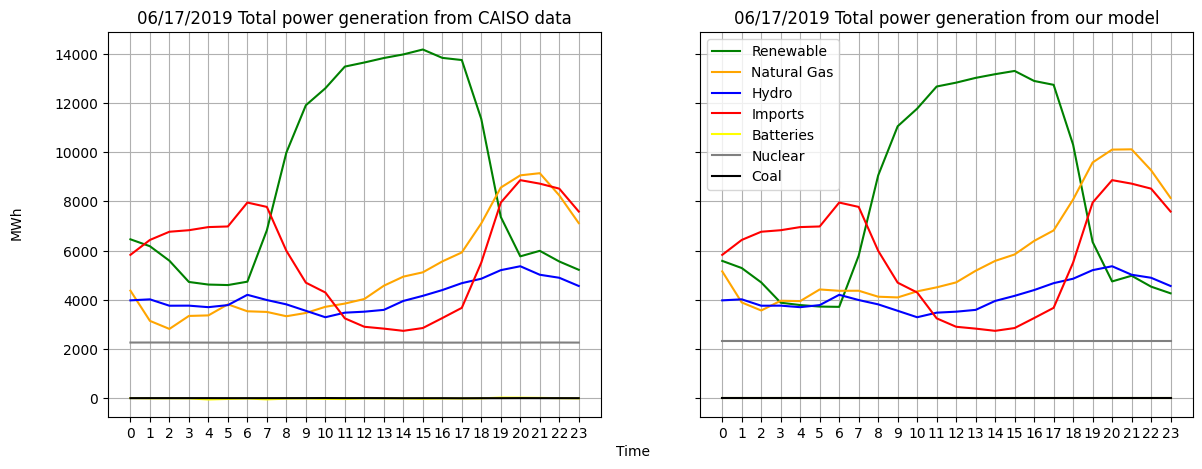

In [295]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
x = [i for i in range(0, 24, 1)]
ax1.plot(x, actual_supply[0], label='Renewable', color='green')
ax1.plot(x, actual_supply[1], label='Natural Gas', color='orange')
ax1.plot(x, actual_supply[2], label='Hydro', color='blue')
ax1.plot(x, actual_supply[3], label='Imports', color='red')
ax1.plot(x, actual_supply[4], label='Batteries', color='yellow')
ax1.plot(x, actual_supply[5], label='Nuclear', color='grey')
ax1.plot(x, actual_supply[6], label='Coal', color='black')
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'MWh', ha='center', va='center', rotation='vertical')
ax1.grid()
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_title("06/17/2019 Total power generation from CAISO data")
ax2.plot(x, pg_time_by_type_copy[2], label='Renewable', color='green')
ax2.plot(x, pg_time_by_type_copy[1], label='Natural Gas', color='orange')
ax2.plot(x, actual_supply[2], label='Hydro', color='blue')
ax2.plot(x, actual_supply[3], label='Imports', color='red')
ax2.plot(x, pg_time_by_type_copy[6], label='Batteries', color='yellow')
ax2.plot(x, pg_time_by_type_copy[7], label='Nuclear', color='grey')
ax2.plot(x, pg_time_by_type_copy[5], label='Coal', color='black')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_title("06/17/2019 Total power generation from our model")
ax2.legend()
ax2.grid()
#fig.tight_layout()

In [296]:
te = pd.read_csv("data/201906/CAISO-co2-per-resource-20190617.csv").to_numpy()[:,1:].T
target_emissions = []
for i in range(0,288):
    if i%12 == 0:
        target_emissions.append(list(te[i,:]))
carb_e_rate = []
pg_time_by_type = np.array(pg_time_by_type[:6,:])
target_emissions = np.array(target_emissions).T

In [297]:
carb_total = np.reshape(np.array(res).T + target_emissions[0], (24,))

In [573]:
'''actual_supply_renew = pd.read_csv("data\CAISO-supply-20190712 - Copy.csv").to_numpy()[:,1:].T
actual_supply_renew_ = []
for i in range(0,288):
    if i%12 == 0:
        actual_supply_renew_.append(list(actual_supply_renew[i,:]))
actual_supply_renew_ = np.array(actual_supply_renew_).T'''

In [577]:
carb_e = []
for i in range(6):
    reg = LinearRegression().fit(np.reshape(actual_supply_renew[i], (24,1)), np.reshape(target_emissions[i], (24,1)))
    carb_e.append(reg.predict(np.reshape(pg_time_by_type[i], (24,1))))
carb_e = np.reshape(np.array(carb_e), (6,24))

NameError: name 'actual_supply_renew' is not defined

In [298]:
tt = pd.read_csv("data/201906/CAISO-co2-20190617.csv").to_numpy()[:,1:].T
real_total_e = []
for i in range(0,288):
    if i%12 == 0:
        real_total_e.append(tt[i])

In [299]:
get_wMAPE(real_total_e, carb_total)

array([0.1208495892824778], dtype=object)

In [300]:
get_MAPE(real_total_e, carb_total)

array([0.1337069834258253], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


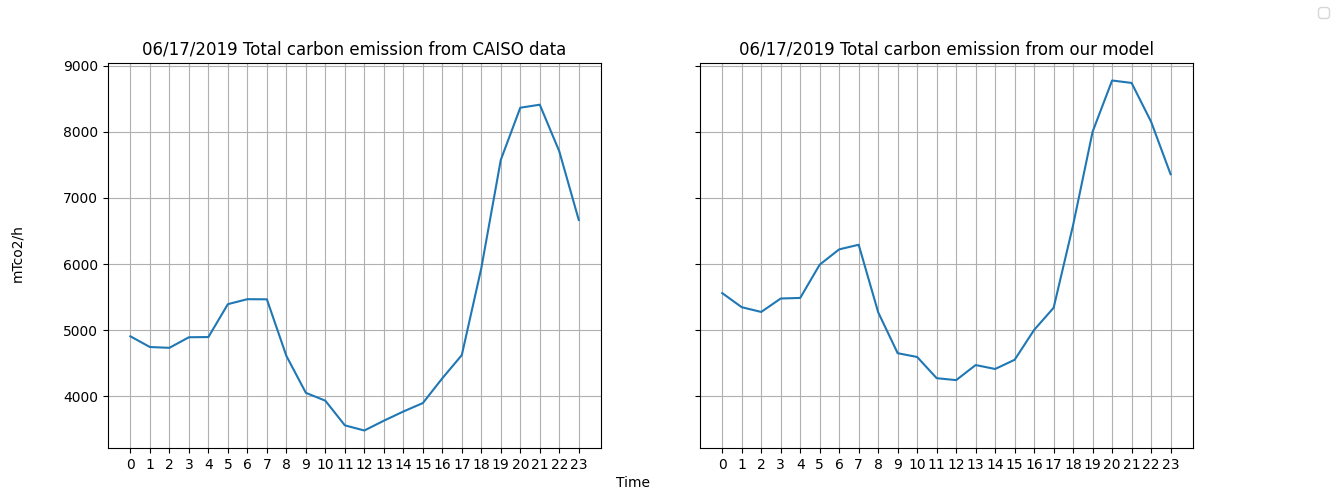

In [301]:
x = [i for i in range(0, 24, 1)]
plt.plot(x, real_total_e, color='b', label='CAISO data')
plt.xlabel("Time")
plt.ylabel("mTco2/h")
plt.xticks(x)
plt.plot(x, carb_total, color='r', label='Result')
plt.title("06/17/2019 Total carbon emission")
plt.legend()
plt.grid()

In [141]:
emi_by_type = np.array(emi_by_type).T

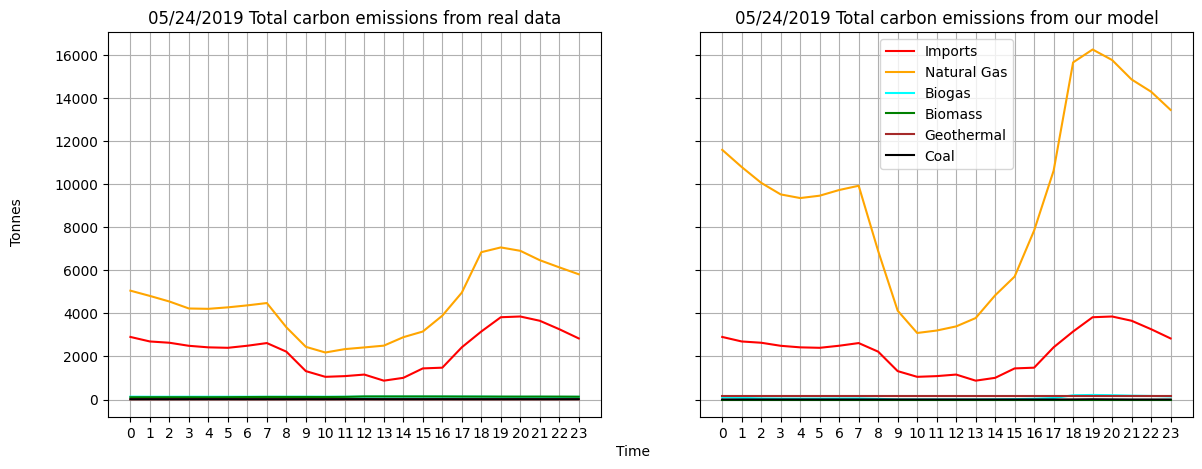

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
#fig.suptitle('Comparison of carbon emissions by fuel type')
x = [i for i in range(0, 24, 1)]
ax1.plot(x, target_emissions[0], label='Imports', color='red')
ax1.plot(x, target_emissions[1], label='Natural Gas', color='orange')
ax1.plot(x, target_emissions[2], label='Biogas', color='cyan')
ax1.plot(x, target_emissions[3], label='Biomass', color='green')
ax1.plot(x, target_emissions[4], label='Geothermal', color='brown')
ax1.plot(x, target_emissions[5], label='Coal', color='black')
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_title("05/24/2019 Total carbon emissions from real data")
ax1.grid()
ax2.plot(x, target_emissions[0], label='Imports', color='red')
ax2.plot(x, emi_by_type[1], label='Natural Gas', color='orange')
ax2.plot(x, emi_by_type[2], label='Biogas', color='cyan')
ax2.plot(x, emi_by_type[3], label='Biomass', color='green')
ax2.plot(x, emi_by_type[4], label='Geothermal', color='brown')
ax2.plot(x, emi_by_type[5], label='Coal', color='black')
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Tonnes', ha='center', va='center', rotation='vertical')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_title("05/24/2019 Total carbon emissions from our model")
ax2.legend()
ax2.grid()
#fig.tight_layout()